# Which GPU to use

In [8]:
multiGPU = False
whichGPU = 1
 
# Select which GPU to use
if(multiGPU):
    from keras.utils.training_utils import multi_gpu_model
else:
    import os
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    # The GPU id to use, usually either "0" or "1"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(whichGPU)
    
# # Do other imports now...

# Load all the functions

In [9]:
%run -i 'arena.py'

# General Parameters

In [10]:
import math

# What data to use
tableBase = '4PpKk'
convertStates = False

# Interactive (just in general if one is asked for confirmations, set to False if on autopilot over night f.x.)
askForConfirmation = False

# NN parameters
filters = [16,32,32,64,128,128,128]
filterShape = [2,2,2,2,2,2,2]
batch_size = 256
optimizer = 'Adam'
useBatchNorm = False
num_classes = 3
input_shape = (4,8,8)

### DON'T MODIFY BELOW ###
# Generate dataset variables
fileName = tableBase + '.hdf5'
dataSetName = tableBase + '_onlyLegal'
if not convertStates: 
    dataSetName = tableBase + '_onlyLegal_fullStates'
dataSetWdlName = tableBase + '_Wdl_onlyLegal_3Values'

# Number of Pieces
nPi =  int(dataSetName[0])
nPa = nPi - 2
nWPa = math.ceil(nPa/2)

# Experiment 8
Converge 3>4


## parameters

In [11]:
%run -i 'arena.py'

# Parameters
# weightsSource = '103' # trained on 3pc from scratch
# weightsSource = '521' # trained on 3pc then 4pc for 150ep
# sourceNet = '107' # trained on 4pc from scratch ######################## MODIFY
epochs = 160
averageOver = 5
optimizer = 'Adadelta'

                          ############################### MODIFY
expDescrBase = "converge 3 to 4 {} epochs".format(epochs, optimizer)

calcIndvWDLvalues = True
saveEveryRun = True # save stuff in results dir
saveWeightsCheckpoints = True # save chkp in results dir
saveBengioCheckPoints = False
saveTensorboardLogs = True # save logs in ./logs dir
compareResultsDuringTraining = False
resID = '---NORESID---' # used when not saving data, but fitModel() still needs a resID

fractionOfDataToUse =1
plotDuringTraining = False
loadWeights = False 
loadCheckpointWeights = False
askForConfirmation = False

### Create model and load data

__________________________________________________ RUN 0
163328
163328
X_train shape: (109429, 4, 8, 8)
y_train shape: (109429, 1)
X_test shape: (53899, 4, 8, 8)
y_test shape: (53899, 1)
109429 train samples
53899 test samples
Done loading dataset
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 16, 7, 7)          272       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 15, 6, 32)         928       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 14, 5, 32)         4128      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 13, 4, 64)         8256      
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 12, 3, 128)        32896     
__________________________

109429/109429 [==============================] - 4s 36us/step - loss: 0.0117 - acc: 0.9958 - val_loss: 0.0280 - val_acc: 0.9907

Epoch 00028: val_acc did not improve from 0.99072
Epoch 29/160
109429/109429 [==============================] - 4s 36us/step - loss: 0.0118 - acc: 0.9958 - val_loss: 0.0273 - val_acc: 0.9904

Epoch 00029: val_acc did not improve from 0.99072
Epoch 30/160
109429/109429 [==============================] - 4s 36us/step - loss: 0.0104 - acc: 0.9963 - val_loss: 0.0415 - val_acc: 0.9865

Epoch 00030: val_acc did not improve from 0.99072
Epoch 31/160
109429/109429 [==============================] - 4s 36us/step - loss: 0.0105 - acc: 0.9964 - val_loss: 0.0279 - val_acc: 0.9908

Epoch 00031: val_acc improved from 0.99072 to 0.99080, saving model to Results/852/weightsCheckpoints/weights-checkp-031-0.991.hdf5
Epoch 32/160
109429/109429 [==============================] - 4s 36us/step - loss: 0.0093 - acc: 0.9969 - val_loss: 0.0408 - val_acc: 0.9872

Epoch 00032: val_acc 

109429/109429 [==============================] - 4s 35us/step - loss: 0.0037 - acc: 0.9990 - val_loss: 0.0351 - val_acc: 0.9924

Epoch 00066: val_acc did not improve from 0.99443
Epoch 67/160
109429/109429 [==============================] - 4s 35us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0236 - val_acc: 0.9942

Epoch 00067: val_acc did not improve from 0.99443
Epoch 68/160
109429/109429 [==============================] - 4s 35us/step - loss: 0.0042 - acc: 0.9989 - val_loss: 0.0310 - val_acc: 0.9929

Epoch 00068: val_acc did not improve from 0.99443
Epoch 69/160
109429/109429 [==============================] - 4s 35us/step - loss: 0.0036 - acc: 0.9990 - val_loss: 0.0319 - val_acc: 0.9926

Epoch 00069: val_acc did not improve from 0.99443
Epoch 70/160
109429/109429 [==============================] - 4s 35us/step - loss: 0.0033 - acc: 0.9991 - val_loss: 0.0389 - val_acc: 0.9914

Epoch 00070: val_acc did not improve from 0.99443
Epoch 71/160
109429/109429 [=========================

109429/109429 [==============================] - 4s 36us/step - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0336 - val_acc: 0.9940

Epoch 00107: val_acc did not improve from 0.99499
Epoch 108/160
109429/109429 [==============================] - 4s 36us/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0280 - val_acc: 0.9944

Epoch 00108: val_acc did not improve from 0.99499
Epoch 109/160
109429/109429 [==============================] - 4s 36us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0371 - val_acc: 0.9930

Epoch 00109: val_acc did not improve from 0.99499
Epoch 110/160
109429/109429 [==============================] - 4s 36us/step - loss: 0.0023 - acc: 0.9994 - val_loss: 0.0380 - val_acc: 0.9931

Epoch 00110: val_acc did not improve from 0.99499
Epoch 111/160
109429/109429 [==============================] - 4s 35us/step - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0383 - val_acc: 0.9928

Epoch 00111: val_acc did not improve from 0.99499
Epoch 112/160
109429/109429 [====================

109429/109429 [==============================] - 4s 36us/step - loss: 4.4248e-04 - acc: 1.0000 - val_loss: 0.0235 - val_acc: 0.9961

Epoch 00147: val_acc improved from 0.99605 to 0.99609, saving model to Results/852/weightsCheckpoints/weights-checkp-147-0.996.hdf5
Epoch 148/160
109429/109429 [==============================] - 4s 36us/step - loss: 4.4247e-04 - acc: 1.0000 - val_loss: 0.0235 - val_acc: 0.9961

Epoch 00148: val_acc did not improve from 0.99609
Epoch 149/160
109429/109429 [==============================] - 4s 36us/step - loss: 4.4246e-04 - acc: 1.0000 - val_loss: 0.0236 - val_acc: 0.9961

Epoch 00149: val_acc improved from 0.99609 to 0.99610, saving model to Results/852/weightsCheckpoints/weights-checkp-149-0.996.hdf5
Epoch 150/160
109429/109429 [==============================] - 4s 35us/step - loss: 4.4244e-04 - acc: 1.0000 - val_loss: 0.0236 - val_acc: 0.9961

Epoch 00150: val_acc did not improve from 0.99610
Epoch 151/160
109429/109429 [==============================] -

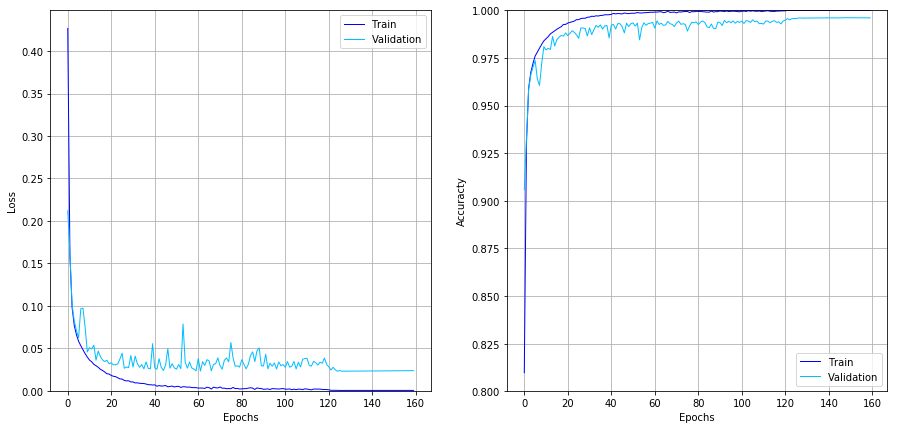

Saving summary...
Saving tensorboard logs...
All done saving stuff!
7436088
7436088
X_train shape: (4982178, 4, 8, 8)
y_train shape: (4982178, 1)
X_test shape: (2453910, 4, 8, 8)
y_test shape: (2453910, 1)
4982178 train samples
2453910 test samples
Done loading dataset
Save dir: Results/853/
Creating save dir
Done generating results dir Results/853/
Saving weights to Results/853/weightsCheckpoints/
Train on 4982178 samples, validate on 2453910 samples
Epoch 1/160
4982178/4982178 [==============================] - 179s 36us/step - loss: 0.2511 - acc: 0.8961 - val_loss: 0.1824 - val_acc: 0.9241

Epoch 00001: val_acc improved from -inf to 0.92411, saving model to Results/853/weightsCheckpoints/weights-checkp-001-0.924.hdf5
Epoch 2/160
4982178/4982178 [==============================] - 179s 36us/step - loss: 0.1597 - acc: 0.9337 - val_loss: 0.1505 - val_acc: 0.9376

Epoch 00002: val_acc improved from 0.92411 to 0.93760, saving model to Results/853/weightsCheckpoints/weights-checkp-002-0.93

4982178/4982178 [==============================] - 176s 35us/step - loss: 0.0659 - acc: 0.9750 - val_loss: 0.0755 - val_acc: 0.9721

Epoch 00033: val_acc improved from 0.97163 to 0.97208, saving model to Results/853/weightsCheckpoints/weights-checkp-033-0.972.hdf5
Epoch 34/160
4982178/4982178 [==============================] - 176s 35us/step - loss: 0.0655 - acc: 0.9753 - val_loss: 0.0764 - val_acc: 0.9715

Epoch 00034: val_acc did not improve from 0.97208
Epoch 35/160
4982178/4982178 [==============================] - 176s 35us/step - loss: 0.0653 - acc: 0.9753 - val_loss: 0.0703 - val_acc: 0.9741

Epoch 00035: val_acc improved from 0.97208 to 0.97407, saving model to Results/853/weightsCheckpoints/weights-checkp-035-0.974.hdf5
Epoch 36/160
4982178/4982178 [==============================] - 175s 35us/step - loss: 0.0648 - acc: 0.9756 - val_loss: 0.0795 - val_acc: 0.9706

Epoch 00036: val_acc did not improve from 0.97407
Epoch 37/160
4982178/4982178 [==============================] - 1

4982178/4982178 [==============================] - 176s 35us/step - loss: 0.0575 - acc: 0.9789 - val_loss: 0.0724 - val_acc: 0.9740

Epoch 00072: val_acc did not improve from 0.97689
Epoch 73/160
4982178/4982178 [==============================] - 176s 35us/step - loss: 0.0575 - acc: 0.9789 - val_loss: 0.0740 - val_acc: 0.9738

Epoch 00073: val_acc did not improve from 0.97689
Epoch 74/160
4982178/4982178 [==============================] - 176s 35us/step - loss: 0.0574 - acc: 0.9789 - val_loss: 0.0671 - val_acc: 0.9764

Epoch 00074: val_acc did not improve from 0.97689
Epoch 75/160
4982178/4982178 [==============================] - 176s 35us/step - loss: 0.0571 - acc: 0.9791 - val_loss: 0.0703 - val_acc: 0.9765

Epoch 00075: val_acc did not improve from 0.97689
Epoch 76/160
4982178/4982178 [==============================] - 175s 35us/step - loss: 0.0569 - acc: 0.9792 - val_loss: 0.0781 - val_acc: 0.9729

Epoch 00076: val_acc did not improve from 0.97689
Epoch 77/160
4982178/4982178 [===

In [ ]:
%run -i arena.py
# stuff to save in bengioResults dir
# resSaveFile = 'conv3to4-startingAt300epochs'
# dictFieldName = 'acc'
# saveDir = 'bengioResults'
# resSaveFile = resSaveFile + '-{}runAverage-{}epochs'.format(averageOver, epochs)
# resSaveFileFullPath = saveDir + '/' + str(resSaveFile) + '.pkl' 

# prepare save file
# if os.path.exists(resSaveFileFullPath):
#     print("Save file exists..., aborting\n")
#     sys.exit()
    
for i in range(averageOver):
    print("__________________________________________________ RUN {}".format(i))
    
########################################################## train on 3pc
    ############################### set 3pc parameters
    # What data to use
    tableBase = '3PKk'
    
    # Generate dataset variables
    fileName = tableBase + '.hdf5'
    dataSetName = tableBase + '_onlyLegal'
    if not convertStates: 
        dataSetName = tableBase + '_onlyLegal_fullStates'
    dataSetWdlName = tableBase + '_Wdl_onlyLegal_3Values'

    # Number of Pieces
    nPi =  int(dataSetName[0])
    nPa = nPi - 2
    nWPa = math.ceil(nPa/2)
    
    # Parameters
    expDescrBase = "converge 3 to 4 - {} epochs - tablebase {}".format(epochs, tableBase)

    ################################# train 3pc
    expDescr = expDescrBase + ' - run {} of {}'.format(i,averageOver)
    # load data
    X_train, X_test, y_train, y_test = loadData(randomState = None)

    # create model
    model, nnStr = createModel()

    # create results dir
    resID = genNextResultsDir(model)

    # train
    fitHistory, logDir = trainModel(resID, model, saveWeightsCheckpoints, saveTensorboardLogs)

    # calc score 
    score, scoreCount = calcScore(model, X_test, y_test, returnCount = True)
    if calcIndvWDLvalues:
        scoreLoss, scoreLossCount= calcScore(model, X_test, y_test,targetWDLvalue = -1, returnCount = True)
        scoreDraw, scoreDrawCount = calcScore(model, X_test, y_test,targetWDLvalue = 0, returnCount = True)
        scoreWin, scoreWinCount = calcScore(model, X_test, y_test,targetWDLvalue = 1, returnCount = True)
    if saveEveryRun:
        saveTrainResults(resID, model, logDir, score)
        
########################################################## transfer to 4pc
    ############################### set 4pc parameters
    # What data to use
    tableBase = '4PpKk'
    
    ### DON'T MODIFY BELOW ###
    # Generate dataset variables
    fileName = tableBase + '.hdf5'
    dataSetName = tableBase + '_onlyLegal'
    if not convertStates: 
        dataSetName = tableBase + '_onlyLegal_fullStates'
    dataSetWdlName = tableBase + '_Wdl_onlyLegal_3Values'

    # Number of Pieces
    nPi =  int(dataSetName[0])
    nPa = nPi - 2
    nWPa = math.ceil(nPa/2)
    
    expDescrBase = "converge 3 to 4 - {} epochs - tablebase {}".format(epochs, tableBase)

    ### train 4pc
    expDescr = expDescrBase + ' - run {} of {}'.format(i,averageOver)
    # load data
    X_train, X_test, y_train, y_test = loadData(randomState = None)

    # create results dir
    resID = genNextResultsDir(model)

    # train
    fitHistory, logDir = trainModel(resID, model, saveWeightsCheckpoints, saveTensorboardLogs)

    # calc score 
    score, scoreCount = calcScore(model, X_test, y_test, returnCount = True)
    if calcIndvWDLvalues:
        scoreLoss, scoreLossCount= calcScore(model, X_test, y_test,targetWDLvalue = -1, returnCount = True)
        scoreDraw, scoreDrawCount = calcScore(model, X_test, y_test,targetWDLvalue = 0, returnCount = True)
        scoreWin, scoreWinCount = calcScore(model, X_test, y_test,targetWDLvalue = 1, returnCount = True)
    if saveEveryRun:
        saveTrainResults(resID, model, logDir, score)
        


In [64]:
sys.exit()

SystemExit: 

/home/frimann/anaconda3/envs/endnetGpu8/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3299: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [56]:
%run -i 'arena.py'

tableBase = '4PpKk'
fileName = tableBase + '.hdf5'

X_train, X_test, y_train, y_test = loadData(randomState = None)

model, nnStr = createModel()

score = calcScore(model, X_test, y_test, targetWDLvalue = -1)

7436088
74360
X_train shape: (49821, 4, 8, 8)
y_train shape: (49821, 1)
X_test shape: (24539, 4, 8, 8)
y_test shape: (24539, 1)
49821 train samples
24539 test samples
Done loading dataset
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_330 (Conv2D)          (None, 16, 7, 7)          272       
_________________________________________________________________
conv2d_331 (Conv2D)          (None, 15, 6, 32)         928       
_________________________________________________________________
conv2d_332 (Conv2D)          (None, 14, 5, 32)         4128      
_________________________________________________________________
conv2d_333 (Conv2D)          (None, 13, 4, 64)         8256      
_________________________________________________________________
conv2d_334 (Conv2D)          (None, 12, 3, 128)        32896     
_________________________________________________________________
conv2d_335 (Conv2D) 

# Experiment 0
Converge 3>4 and rnd>4

## parameters

In [ ]:
%run -i 'arena.py'

# Parameters
# weightsSource = '103' # trained on 3pc from scratch
weightsSource = '521' # trained on 3pc then 4pc for 150ep
# sourceNet = '107' # trained on 4pc from scratch ######################## MODIFY
epochs = 10
averageOver = 1
                          ############################### MODIFY
expDescrBaseName = "converge 3to4 - {} averages - {} epochs".format(averageOver, epochs)

saveEveryRun = True # save stuff in results dir
saveWeightsCheckpoints = False # save chkp in results dir
saveBengioCheckPoints = True
saveTensorboardLogs = True # save logs in ./logs dir
compareResultsDuringTraining = False
resID = '---NORESID---' # used when not saving data, but fitModel() still needs a resID

fractionOfDataToUse = 0.0001
plotDuringTraining = True
loadWeights = True 
loadCheckpointWeights = False
askForConfirmation = False

# stuff to save in bengioResults dir
resSaveFile = 'conv3to4-startingAt300epochs'
dictFieldName = 'acc'
saveDir = 'bengioResults'
resSaveFile = resSaveFile + '-{}runAverage-{}epochs'.format(averageOver, epochs)
resSaveFileFullPath = saveDir + '/' + str(resSaveFile) + '.pkl' 
# resSaveFileAllRuns = resSaveFile + '-allRuns'.format(averageOver, epochs)
# resSaveFileAllRunsFullPath = saveDir + '/' + str(resSaveFileAllRuns) + '.pkl' 
# resSaveFileThisRun = resSaveFile + '-thisRun'.format(averageOver, epochs)
# resSaveFileThisRunFullPath = saveDir + '/' + str(resSaveFileThisRun) + '.pkl' 

### Create model and load data

In [ ]:
# prepare save file
if not os.path.exists(resSaveFileFullPath):
    print("Save file doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFile, {dictFieldName:[]})
else:
    print("Save file exists...\n")
    
# load data
X_train, X_test, y_train, y_test = loadData(randomState = None)

# create model
# model, nnStr = createModel()

# load old results
results = load_obj(saveDir, resSaveFile)
# resultsAllRuns = load_obj(saveDir, resSaveFileAllRuns)
# resultsThisRun = load_obj(saveDir, resSaveFileThisRun)

# initialize variables wrt old results
# startTrainingAtLayer = len(results)
# print("\nStarting/restarting TL at {} transfered layers".format(startTrainingAtLayer))
# startThisRunAt = len(resultsThisRun)
startThisRunAt = len(results[dictFieldName])
print("\nStarting/restarting TL at average {}".format(startThisRunAt))

In [ ]:
print(results)

### Train

In [ ]:
%run -i 'arena.py'

# train and average results
for a in range(startThisRunAt,averageOver):
    print('    ==================================================================================')
    print('    =                                                                                =')
    print('    =                Currently at run {}, out of {}                                   ='.format(a+1,averageOver))
    print('    =                                                                                =')
    print('    ==================================================================================')
    print()

    # set experement description test
#     expDescr = expDescrBaseName + '__copyLayers_{}__average_{}_of_{}'.format(copyFirstNLayers, a+1, averageOver)
    expDescr = expDescrBaseName + '__average_{}_of_{}'.format(a+1, averageOver)

    # save current averagePosition to tmp file
    with open(saveDir + '/' + str(resSaveFile) + '_currentPosition.txt','w') as file:
        file.write('Inner avg loop position: {} out of {}'.format(a+1, averageOver))         

    # load Model layers
#     model = loadNFirstLayers(model, sourceNet, copyFirstNLayers , freeze)
    model, nnStr = createModel()

    # load data
    X_train, X_test, y_train, y_test = loadData(randomState = None)
    
    # Prepare save dir
    if saveEveryRun:
        resID = genNextResultsDir(model)

    # train
    fitHistory, logDir = trainModel(resID, model, saveWeightsCheckpoints, saveTensorboardLogs)

    # calc score 
    score = calcScore(model)
    results[dictFieldName].append(score[1])
    if saveEveryRun:
        saveTrainResults(resID, model, logDir, score)

    # save checkpoint
    if saveBengioCheckPoints:
        dateTime = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime())

        src = saveDir + '/' + str(resSaveFile) + '.pkl'
        dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.pkl'
        if os.path.exists(src):
            shutil.move(src, dest)

        src = saveDir + '/' + str(resSaveFile) + '.txt'
        dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.txt'
        if os.path.exists(src):
            shutil.move(src, dest)

    # save results 
    save_obj(saveDir, resSaveFile, results)
    with open(saveDir + '/' + str(resSaveFile) + '.txt','w') as file:
        file.write(str(results))


print('\n Final Results: {}'.format(results))
print('\n Final Results Averate: {}'.format(np.mean(np.array(results[dictFieldName]))))


In [ ]:
dateTime = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime())

src = saveDir + '/' + str(resSaveFile) + '.pkl'
dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.pkl'
if os.path.exists(src):
    shutil.move(src, dest)

src = saveDir + '/' + str(resSaveFile) + '.txt'
dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.txt'
if os.path.exists(src):
    shutil.move(src, dest)

# save results 
save_obj(saveDir, resSaveFile, results)
with open(saveDir + '/' + str(resSaveFile) + '.txt','w') as file:
    file.write(str(results))

In [ ]:
sys.exit()

# Experiment 4
Bengio methood
4n4

## parameters

In [ ]:
%run -i 'arena.py'

# Parameters
# sourceNet = '103' # trained on 3pc from scratch
sourceNet = '107' # trained on 4pc from scratch ######################## MODIFY
freeze = True                           ############################### MODIFY
epochs = 10
averageOver = 5 
                          ############################### MODIFY
expDescrBaseName = "Bengio 4n4 - freeze = {} - average over {} runs - {} epochs".format(str(freeze), averageOver, epochs)

saveEveryRun = True # save stuff in results dir
saveWeightsCheckpoints = False # save chkp in results dit
saveTensorboardLogs = True # save logs in ./logs dir
resID = '---NORESID---' # used when not saving data, but fitModel() still needs a resID

fractionOfDataToUse = 1
plotDuringTraining = False
loadWeights = False #only used in createModel function, the loadFirstNLayers always loads weights! 
askForConfirmation = False

# stuff to save in bengioResults dir
resSaveFile = '4n4'
saveDir = 'bengioResults'
# resSaveFile = resSaveFile + '-{}runAverage-{}epochs'.format(averageOver, epochs)
resSaveFileFullPath = saveDir + '/' + str(resSaveFile) + '.pkl' 
resSaveFileAllRuns = resSaveFile + '-allRuns'.format(averageOver, epochs)
resSaveFileAllRunsFullPath = saveDir + '/' + str(resSaveFileAllRuns) + '.pkl' 
resSaveFileThisRun = resSaveFile + '-thisRun'.format(averageOver, epochs)
resSaveFileThisRunFullPath = saveDir + '/' + str(resSaveFileThisRun) + '.pkl' 

### Create model and load data

In [ ]:
# prepare save file
if not os.path.exists(resSaveFileFullPath):
    print("Save file doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFile, [])
else:
    print("Save file exists...\n")
    
if not os.path.exists(resSaveFileAllRunsFullPath):
    print("Save file for all runs doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFileAllRuns, [])
else:
    print("Save file for all runs exists...\n")

if not os.path.exists(resSaveFileThisRunFullPath):
    print("Save file for this run doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFileThisRun, [])
else:
    print("Save file for this run exists...\n")

# load data
X_train, X_test, y_train, y_test = loadData(randomState = None)

# create model
model, nnStr = createModel()
layersCount = len(model.layers)

# load old results
results = load_obj(saveDir, resSaveFile)
resultsAllRuns = load_obj(saveDir, resSaveFileAllRuns)
resultsThisRun = load_obj(saveDir, resSaveFileThisRun)

# initialize variables wrt old results
startTrainingAtLayer = len(results)
print("\nStarting/restarting TL at {} transfered layers".format(startTrainingAtLayer))
# startThisRunAt = len(resultsThisRun)
# print("\nStarting/restarting TL at average {}".format(startTrainingAtLayer))

In [ ]:
print(results)
print(resultsThisRun)
print(resultsAllRuns)

### Train

In [ ]:
%run -i 'arena.py'

for copyFirstNLayers in range(startTrainingAtLayer, layersCount):
    print('\n\n')
    print('==========================================================================================')
    print('=                                                                                        =')
    print('=                    Currently transfering first {} layers, out of {}                      ='.format(copyFirstNLayers, layersCount - 1))
    print('=                                                                                        =')
    print('==========================================================================================')
    print()
    
    # check if we are at the flatten layer, and skip it if so
    if copyFirstNLayers == layersCount - 1:
        copyFirstNLayers += 1
        
#     # start accumulated score from load file in case of starting from average run ≠ 0
#     accumulatedScore = np.sum(resultsThisRun)

    # Reset variables
    resultsThisRun = []
    accumulatedScore = 0
    
    # train and average results
    for a in range(averageOver):
        print('    ==================================================================================')
        print('    =                                                                                =')
        print('    =                Currently at run {}, out of {}                                   ='.format(a+1,averageOver))
        print('    =                                                                                =')
        print('    ==================================================================================')
        print()
        
        # set experement description test
        expDescr = expDescrBaseName + '__copyLayers_{}__average_{}_of_{}'.format(copyFirstNLayers, a+1, averageOver)
        
        # save current averagePosition to tmp file
        with open(saveDir + '/' + str(resSaveFile) + '_currentPosition.txt','w') as file:
            if copyFirstNLayers == layersCount:
                location = copyFirstNLayers - 1
            else:
                location = copyFirstNLayers 
            file.write('Layers Transfered: {} out of {} \nInner avg loop position: {} out of {}'.format(location, layersCount-1, a+1, averageOver))         
            
        # load Model layers
        model = loadNFirstLayers(model, sourceNet, copyFirstNLayers , freeze)

        # load data
        X_train, X_test, y_train, y_test = loadData(randomState = None)

        # Prepare save dir
        if saveEveryRun:
            resID = genNextResultsDir(model)

        # train
        fitHistory, logDir = trainModel(resID, model, saveWeightsCheckpoints, saveTensorboardLogs)

        # score and save results
        score = calcScore(model)
        if saveEveryRun:
            saveTrainResults(resID, model, logDir, score, copyFirstNLayers)

        # update Return
        accumulatedScore += score[1]
        resultsThisRun.append(score[1])
        
        # save bengio checkpoint
        dateTime = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime())
        
        src = saveDir + '/' + str(resSaveFileThisRun) + '.pkl'
        dest = saveDir + '/checkpoints/' + str(resSaveFileThisRun) + dateTime + '.pkl'
        if os.path.exists(src):
            shutil.move(src, dest)
            
        src = saveDir + '/' + str(resSaveFileThisRun) + '.txt'
        dest = saveDir + '/checkpoints/' + str(resSaveFileThisRun) + dateTime + '.txt'
        if os.path.exists(src):
            shutil.move(src, dest)
        
        # save results 
        save_obj(saveDir, resSaveFileThisRun, resultsThisRun)
        with open(saveDir + '/' + str(resSaveFileThisRun) + '.txt','w') as file:
            file.write(str(resultsThisRun))
            
    # append averaged results for one set of layers
    results.append(accumulatedScore/averageOver)
    resultsAllRuns.append(resultsThisRun)

    # save old results to checkpoints dir
    dateTime = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime())
    
    src = saveDir + '/' + str(resSaveFile) + '.txt'
    dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.txt'
    if os.path.exists(src):
        shutil.move(src, dest)
        
    src = saveDir + '/' + str(resSaveFile) + '.pkl'
    dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.pkl'
    if os.path.exists(src):
        shutil.move(src, dest)

    src = saveDir + '/' + str(resSaveFileAllRuns) + '.txt'
    dest = saveDir + '/checkpoints/' + str(resSaveFileAllRuns) + dateTime + '.txt'
    if os.path.exists(src):
        shutil.move(src, dest)
        
    src = saveDir + '/' + str(resSaveFileAllRuns) + '.pkl'
    dest = saveDir + '/checkpoints/' + str(resSaveFileAllRuns) + dateTime + '.pkl'
    if os.path.exists(src):
        shutil.move(src, dest)
        
    # save results 
    save_obj(saveDir, resSaveFile, results)
    with open(saveDir + '/' + str(resSaveFile) + '.txt','w') as file:
        file.write(str(results))
    
    save_obj(saveDir, resSaveFileAllRuns, resultsAllRuns)
    with open(saveDir + '/' + str(resSaveFileAllRuns) + '.txt','w') as file:
        file.write(str(resultsAllRuns))
    
print('\n Final Results: {}'.format(results))

# Experiment 5
Bengio methood
4n4

## exp  parameters

In [ ]:
%run -i 'arena.py'

# Parameters
# sourceNet = '103' # trained on 3pc from scratch
sourceNet = '107' # trained on 4pc from scratch ######################## MODIFY
freeze = True                           ############################### MODIFY
epochs = 10
averageOver = 5 
                          ############################### MODIFY
expDescrBaseName = "Bengio 4n4 - freeze = {} - average over {} runs - {} epochs".format(str(freeze), averageOver, epochs)

saveEveryRun = True # save stuff in results dir
saveWeightsCheckpoints = False # save chkp in results dit
saveTensorboardLogs = True # save logs in ./logs dir
resID = '---NORESID---' # used when not saving data, but fitModel() still needs a resID

fractionOfDataToUse = 1
plotDuringTraining = False
loadWeights = False 
askForConfirmation = False

# stuff to save in bengioResults dir
resSaveFile = '4n4p'
saveDir = 'bengioResults'
# resSaveFile = resSaveFile + '-{}runAverage-{}epochs'.format(averageOver, epochs)
resSaveFileFullPath = saveDir + '/' + str(resSaveFile) + '.pkl' 
resSaveFileAllRuns = resSaveFile + '-allRuns'.format(averageOver, epochs)
resSaveFileAllRunsFullPath = saveDir + '/' + str(resSaveFileAllRuns) + '.pkl' 
resSaveFileThisRun = resSaveFile + '-thisRun'.format(averageOver, epochs)
resSaveFileThisRunFullPath = saveDir + '/' + str(resSaveFileThisRun) + '.pkl' 

### Create model and load data

In [ ]:
# prepare save file
if not os.path.exists(resSaveFileFullPath):
    print("Save file doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFile, [])
else:
    print("Save file exists...\n")
    
if not os.path.exists(resSaveFileAllRunsFullPath):
    print("Save file for all runs doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFileAllRuns, [])
else:
    print("Save file for all runs exists...\n")

if not os.path.exists(resSaveFileThisRunFullPath):
    print("Save file for this run doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFileThisRun, [])
else:
    print("Save file for this run exists...\n")

# load data
X_train, X_test, y_train, y_test = loadData(randomState = None)

# create model
model, nnStr = createModel()
layersCount = len(model.layers)

# load old results
results = load_obj(saveDir, resSaveFile)
resultsAllRuns = load_obj(saveDir, resSaveFileAllRuns)
resultsThisRun = load_obj(saveDir, resSaveFileThisRun)

# initialize variables wrt old results
startTrainingAtLayer = len(results)
print("\nStarting/restarting TL at {} transfered layers".format(startTrainingAtLayer))
# startThisRunAt = len(resultsThisRun)
# print("\nStarting/restarting TL at average {}".format(startTrainingAtLayer))

In [ ]:
print(results)
print(resultsThisRun)
print(resultsAllRuns)

### Train

In [ ]:
%run -i 'arena.py'

for copyFirstNLayers in range(startTrainingAtLayer, layersCount):
    print('\n\n')
    print('==========================================================================================')
    print('=                                                                                        =')
    print('=                    Currently transfering first {} layers, out of {}                      ='.format(copyFirstNLayers, layersCount - 1))
    print('=                                                                                        =')
    print('==========================================================================================')
    print()
    
    # check if we are at the flatten layer, and skip it if so
    if copyFirstNLayers == layersCount - 1:
        copyFirstNLayers += 1
        
#     # start accumulated score from load file in case of starting from average run ≠ 0
#     accumulatedScore = np.sum(resultsThisRun)

    # Reset variables
    resultsThisRun = []
    accumulatedScore = 0
    
    # train and average results
    for a in range(averageOver):
        print('    ==================================================================================')
        print('    =                                                                                =')
        print('    =                Currently at run {}, out of {}                                   ='.format(a+1,averageOver))
        print('    =                                                                                =')
        print('    ==================================================================================')
        print()
        
        # set experement description test
        expDescr = expDescrBaseName + '__copyLayers_{}__average_{}_of_{}'.format(copyFirstNLayers, a+1, averageOver)
        
        # save current averagePosition to tmp file
        with open(saveDir + '/' + str(resSaveFile) + '_currentPosition.txt','w') as file:
            if copyFirstNLayers == layersCount:
                location = copyFirstNLayers - 1
            else:
                location = copyFirstNLayers 
            file.write('Layers Transfered: {} out of {} \nInner avg loop position: {} out of {}'.format(location, layersCount-1, a+1, averageOver))         
            
        # load Model layers
        model = loadNFirstLayers(model, sourceNet, copyFirstNLayers , freeze)

        # load data
        X_train, X_test, y_train, y_test = loadData(randomState = None)

        # Prepare save dir
        if saveEveryRun:
            resID = genNextResultsDir(model)

        # train
        fitHistory, logDir = trainModel(resID, model, saveWeightsCheckpoints, saveTensorboardLogs)

        # score and save results
        score = calcScore(model)
        if saveEveryRun:
            saveTrainResults(resID, model, logDir, score, copyFirstNLayers)

        # update Return
        accumulatedScore += score[1]
        resultsThisRun.append(score[1])
        
        # save bengio checkpoint
        dateTime = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime())
        
        src = saveDir + '/' + str(resSaveFileThisRun) + '.pkl'
        dest = saveDir + '/checkpoints/' + str(resSaveFileThisRun) + dateTime + '.pkl'
        if os.path.exists(src):
            shutil.move(src, dest)
            
        src = saveDir + '/' + str(resSaveFileThisRun) + '.txt'
        dest = saveDir + '/checkpoints/' + str(resSaveFileThisRun) + dateTime + '.txt'
        if os.path.exists(src):
            shutil.move(src, dest)
        
        # save results 
        save_obj(saveDir, resSaveFileThisRun, resultsThisRun)
        with open(saveDir + '/' + str(resSaveFileThisRun) + '.txt','w') as file:
            file.write(str(resultsThisRun))
            
    # append averaged results for one set of layers
    results.append(accumulatedScore/averageOver)
    resultsAllRuns.append(resultsThisRun)

    # save old results to checkpoints dir
    dateTime = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime())
    
    src = saveDir + '/' + str(resSaveFile) + '.txt'
    dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.txt'
    if os.path.exists(src):
        shutil.move(src, dest)
        
    src = saveDir + '/' + str(resSaveFile) + '.pkl'
    dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.pkl'
    if os.path.exists(src):
        shutil.move(src, dest)

    src = saveDir + '/' + str(resSaveFileAllRuns) + '.txt'
    dest = saveDir + '/checkpoints/' + str(resSaveFileAllRuns) + dateTime + '.txt'
    if os.path.exists(src):
        shutil.move(src, dest)
        
    src = saveDir + '/' + str(resSaveFileAllRuns) + '.pkl'
    dest = saveDir + '/checkpoints/' + str(resSaveFileAllRuns) + dateTime + '.pkl'
    if os.path.exists(src):
        shutil.move(src, dest)
        
    # save results 
    save_obj(saveDir, resSaveFile, results)
    with open(saveDir + '/' + str(resSaveFile) + '.txt','w') as file:
        file.write(str(results))
    
    save_obj(saveDir, resSaveFileAllRuns, resultsAllRuns)
    with open(saveDir + '/' + str(resSaveFileAllRuns) + '.txt','w') as file:
        file.write(str(resultsAllRuns))
    
print('\n Final Results: {}'.format(results))

In [ ]:
sys.exit()

# Experiment 1
Bengio methood
3n4+

## exp 1 parameters

In [ ]:
%run -i 'arena.py'

# Parameters
sourceNet = '103' # trained on 3pc from scratch
# sourceNet = '107' # trained on 4pc from scratch ######################## MODIFY
freeze = False                           ############################### MODIFY
epochs = 10
averageOver = 5 
                          ############################### MODIFY
expDescrBaseName = "Bengio 3n4 - freeze = {} - average over {} runs - {} epochs".format(str(freeze), averageOver, epochs)

saveEveryRun = True # save stuff in results dir
saveWeightsCheckpoints = False # save chkp in results dit
saveTensorboardLogs = True # save logs in ./logs dir
resID = '---NORESID---' # used when not saving data, but fitModel() still needs a resID

fractionOfDataToUse = 1
plotDuringTraining = False
loadWeights = False 
askForConfirmation = False

# stuff to save in bengioResults dir
resSaveFile = '3n4'
saveDir = 'bengioResults'
# resSaveFile = resSaveFile + '-{}runAverage-{}epochs'.format(averageOver, epochs)
resSaveFileFullPath = saveDir + '/' + str(resSaveFile) + '.pkl' 
resSaveFileAllRuns = resSaveFile + '-allRuns'.format(averageOver, epochs)
resSaveFileAllRunsFullPath = saveDir + '/' + str(resSaveFileAllRuns) + '.pkl' 
resSaveFileThisRun = resSaveFile + '-thisRun'.format(averageOver, epochs)
resSaveFileThisRunFullPath = saveDir + '/' + str(resSaveFileThisRun) + '.pkl' 

### Create model and load data

In [ ]:
# prepare save file
if not os.path.exists(resSaveFileFullPath):
    print("Save file doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFile, [])
else:
    print("Save file exists...\n")
    
if not os.path.exists(resSaveFileAllRunsFullPath):
    print("Save file for all runs doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFileAllRuns, [])
else:
    print("Save file for all runs exists...\n")

if not os.path.exists(resSaveFileThisRunFullPath):
    print("Save file for this run doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFileThisRun, [])
else:
    print("Save file for this run exists...\n")

# load data
X_train, X_test, y_train, y_test = loadData(randomState = None)

# create model
model, nnStr = createModel()
layersCount = len(model.layers)

# load old results
results = load_obj(saveDir, resSaveFile)
resultsAllRuns = load_obj(saveDir, resSaveFileAllRuns)
resultsThisRun = load_obj(saveDir, resSaveFileThisRun)

# initialize variables wrt old results
startTrainingAtLayer = len(results)
print("\nStarting/restarting TL at {} transfered layers".format(startTrainingAtLayer))
# startThisRunAt = len(resultsThisRun)
# print("\nStarting/restarting TL at average {}".format(startTrainingAtLayer))

In [ ]:
print(results)
print(resultsThisRun)
print(resultsAllRuns)

### Train

In [ ]:
%run -i 'arena.py'

for copyFirstNLayers in range(startTrainingAtLayer, layersCount):
    print('\n\n')
    print('==========================================================================================')
    print('=                                                                                        =')
    print('=                    Currently transfering first {} layers, out of {}                      ='.format(copyFirstNLayers, layersCount - 1))
    print('=                                                                                        =')
    print('==========================================================================================')
    print()
    
    # check if we are at the flatten layer, and skip it if so
    if copyFirstNLayers == layersCount - 1:
        copyFirstNLayers += 1
        
#     # start accumulated score from load file in case of starting from average run ≠ 0
#     accumulatedScore = np.sum(resultsThisRun)

    # Reset variables
    resultsThisRun = []
    accumulatedScore = 0
    
    # train and average results
    for a in range(averageOver):
        print('    ==================================================================================')
        print('    =                                                                                =')
        print('    =                Currently at run {}, out of {}                                   ='.format(a+1,averageOver))
        print('    =                                                                                =')
        print('    ==================================================================================')
        print()
        
        # set experement description test
        expDescr = expDescrBaseName + '__copyLayers_{}__average_{}_of_{}'.format(copyFirstNLayers, a+1, averageOver)
        
        # save current averagePosition to tmp file
        with open(saveDir + '/' + str(resSaveFile) + '_currentPosition.txt','w') as file:
            if copyFirstNLayers == layersCount:
                location = copyFirstNLayers - 1
            else:
                location = copyFirstNLayers 
            file.write('Layers Transfered: {} out of {} \nInner avg loop position: {} out of {}'.format(location, layersCount-1, a+1, averageOver))         
            
        # load Model layers
        model = loadNFirstLayers(model, sourceNet, copyFirstNLayers , freeze)

        # load data
        X_train, X_test, y_train, y_test = loadData(randomState = None)

        # Prepare save dir
        if saveEveryRun:
            resID = genNextResultsDir(model)

        # train
        fitHistory, logDir = trainModel(resID, model, saveWeightsCheckpoints, saveTensorboardLogs)

        # score and save results
        score = calcScore(model)
        if saveEveryRun:
            saveTrainResults(resID, model, logDir, score, copyFirstNLayers)

        # update Return
        accumulatedScore += score[1]
        resultsThisRun.append(score[1])
        
        # save bengio checkpoint
        dateTime = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime())
        
        src = saveDir + '/' + str(resSaveFileThisRun) + '.pkl'
        dest = saveDir + '/checkpoints/' + str(resSaveFileThisRun) + dateTime + '.pkl'
        if os.path.exists(src):
            shutil.move(src, dest)
            
        src = saveDir + '/' + str(resSaveFileThisRun) + '.txt'
        dest = saveDir + '/checkpoints/' + str(resSaveFileThisRun) + dateTime + '.txt'
        if os.path.exists(src):
            shutil.move(src, dest)
        
        # save results 
        save_obj(saveDir, resSaveFileThisRun, resultsThisRun)
        with open(saveDir + '/' + str(resSaveFileThisRun) + '.txt','w') as file:
            file.write(str(resultsThisRun))
            
    # append averaged results for one set of layers
    results.append(accumulatedScore/averageOver)
    resultsAllRuns.append(resultsThisRun)

    # save old results to checkpoints dir
    dateTime = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime())
    
    src = saveDir + '/' + str(resSaveFile) + '.txt'
    dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.txt'
    if os.path.exists(src):
        shutil.move(src, dest)
        
    src = saveDir + '/' + str(resSaveFile) + '.pkl'
    dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.pkl'
    if os.path.exists(src):
        shutil.move(src, dest)

    src = saveDir + '/' + str(resSaveFileAllRuns) + '.txt'
    dest = saveDir + '/checkpoints/' + str(resSaveFileAllRuns) + dateTime + '.txt'
    if os.path.exists(src):
        shutil.move(src, dest)
        
    src = saveDir + '/' + str(resSaveFileAllRuns) + '.pkl'
    dest = saveDir + '/checkpoints/' + str(resSaveFileAllRuns) + dateTime + '.pkl'
    if os.path.exists(src):
        shutil.move(src, dest)
        
    # save results 
    save_obj(saveDir, resSaveFile, results)
    with open(saveDir + '/' + str(resSaveFile) + '.txt','w') as file:
        file.write(str(results))
    
    save_obj(saveDir, resSaveFileAllRuns, resultsAllRuns)
    with open(saveDir + '/' + str(resSaveFileAllRuns) + '.txt','w') as file:
        file.write(str(resultsAllRuns))
    
print('\n Final Results: {}'.format(results))

# Experiment 2
Bengio methood
3n4

## exp  parameters

In [ ]:
%run -i 'arena.py'

# Parameters
sourceNet = '103' # trained on 3pc from scratch
# sourceNet = '107' # trained on 4pc from scratch ######################## MODIFY
freeze = True                           ############################### MODIFY
epochs = 10
averageOver = 5 
                          ############################### MODIFY
expDescrBaseName = "Bengio 3n4 - freeze = {} - average over {} runs - {} epochs".format(str(freeze), averageOver, epochs)

saveEveryRun = True # save stuff in results dir
saveWeightsCheckpoints = False # save chkp in results dit
saveTensorboardLogs = True # save logs in ./logs dir
resID = '---NORESID---' # used when not saving data, but fitModel() still needs a resID

fractionOfDataToUse = 1
plotDuringTraining = False
loadWeights = False 
askForConfirmation = False

# stuff to save in bengioResults dir
resSaveFile = '3n4p'
saveDir = 'bengioResults'
# resSaveFile = resSaveFile + '-{}runAverage-{}epochs'.format(averageOver, epochs)
resSaveFileFullPath = saveDir + '/' + str(resSaveFile) + '.pkl' 
resSaveFileAllRuns = resSaveFile + '-allRuns'.format(averageOver, epochs)
resSaveFileAllRunsFullPath = saveDir + '/' + str(resSaveFileAllRuns) + '.pkl' 
resSaveFileThisRun = resSaveFile + '-thisRun'.format(averageOver, epochs)
resSaveFileThisRunFullPath = saveDir + '/' + str(resSaveFileThisRun) + '.pkl' 

### Create model and load data

In [ ]:
# prepare save file
if not os.path.exists(resSaveFileFullPath):
    print("Save file doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFile, [])
else:
    print("Save file exists...\n")
    
if not os.path.exists(resSaveFileAllRunsFullPath):
    print("Save file for all runs doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFileAllRuns, [])
else:
    print("Save file for all runs exists...\n")

if not os.path.exists(resSaveFileThisRunFullPath):
    print("Save file for this run doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFileThisRun, [])
else:
    print("Save file for this run exists...\n")

# load data
X_train, X_test, y_train, y_test = loadData(randomState = None)

# create model
model, nnStr = createModel()
layersCount = len(model.layers)

# load old results
results = load_obj(saveDir, resSaveFile)
resultsAllRuns = load_obj(saveDir, resSaveFileAllRuns)
resultsThisRun = load_obj(saveDir, resSaveFileThisRun)

# initialize variables wrt old results
startTrainingAtLayer = len(results)
print("\nStarting/restarting TL at {} transfered layers".format(startTrainingAtLayer))
# startThisRunAt = len(resultsThisRun)
# print("\nStarting/restarting TL at average {}".format(startTrainingAtLayer))

In [ ]:
print(results)
print(resultsThisRun)
print(resultsAllRuns)

### Train

In [ ]:
%run -i 'arena.py'

for copyFirstNLayers in range(startTrainingAtLayer, layersCount):
    print('\n\n')
    print('==========================================================================================')
    print('=                                                                                        =')
    print('=                    Currently transfering first {} layers, out of {}                      ='.format(copyFirstNLayers, layersCount - 1))
    print('=                                                                                        =')
    print('==========================================================================================')
    print()
    
    # check if we are at the flatten layer, and skip it if so
    if copyFirstNLayers == layersCount - 1:
        copyFirstNLayers += 1
        
#     # start accumulated score from load file in case of starting from average run ≠ 0
#     accumulatedScore = np.sum(resultsThisRun)

    # Reset variables
    resultsThisRun = []
    accumulatedScore = 0
    
    # train and average results
    for a in range(averageOver):
        print('    ==================================================================================')
        print('    =                                                                                =')
        print('    =                Currently at run {}, out of {}                                   ='.format(a+1,averageOver))
        print('    =                                                                                =')
        print('    ==================================================================================')
        print()
        
        # set experement description test
        expDescr = expDescrBaseName + '__copyLayers_{}__average_{}_of_{}'.format(copyFirstNLayers, a+1, averageOver)
        
        # save current averagePosition to tmp file
        with open(saveDir + '/' + str(resSaveFile) + '_currentPosition.txt','w') as file:
            if copyFirstNLayers == layersCount:
                location = copyFirstNLayers - 1
            else:
                location = copyFirstNLayers 
            file.write('Layers Transfered: {} out of {} \nInner avg loop position: {} out of {}'.format(location, layersCount-1, a+1, averageOver))         
            
        # load Model layers
        model = loadNFirstLayers(model, sourceNet, copyFirstNLayers , freeze)

        # load data
        X_train, X_test, y_train, y_test = loadData(randomState = None)

        # Prepare save dir
        if saveEveryRun:
            resID = genNextResultsDir(model)

        # train
        fitHistory, logDir = trainModel(resID, model, saveWeightsCheckpoints, saveTensorboardLogs)

        # score and save results
        score = calcScore(model)
        if saveEveryRun:
            saveTrainResults(resID, model, logDir, score, copyFirstNLayers)

        # update Return
        accumulatedScore += score[1]
        resultsThisRun.append(score[1])
        
        # save bengio checkpoint
        dateTime = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime())
        
        src = saveDir + '/' + str(resSaveFileThisRun) + '.pkl'
        dest = saveDir + '/checkpoints/' + str(resSaveFileThisRun) + dateTime + '.pkl'
        if os.path.exists(src):
            shutil.move(src, dest)
            
        src = saveDir + '/' + str(resSaveFileThisRun) + '.txt'
        dest = saveDir + '/checkpoints/' + str(resSaveFileThisRun) + dateTime + '.txt'
        if os.path.exists(src):
            shutil.move(src, dest)
        
        # save results 
        save_obj(saveDir, resSaveFileThisRun, resultsThisRun)
        with open(saveDir + '/' + str(resSaveFileThisRun) + '.txt','w') as file:
            file.write(str(resultsThisRun))
            
    # append averaged results for one set of layers
    results.append(accumulatedScore/averageOver)
    resultsAllRuns.append(resultsThisRun)

    # save old results to checkpoints dir
    dateTime = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime())
    
    src = saveDir + '/' + str(resSaveFile) + '.txt'
    dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.txt'
    if os.path.exists(src):
        shutil.move(src, dest)
        
    src = saveDir + '/' + str(resSaveFile) + '.pkl'
    dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.pkl'
    if os.path.exists(src):
        shutil.move(src, dest)

    src = saveDir + '/' + str(resSaveFileAllRuns) + '.txt'
    dest = saveDir + '/checkpoints/' + str(resSaveFileAllRuns) + dateTime + '.txt'
    if os.path.exists(src):
        shutil.move(src, dest)
        
    src = saveDir + '/' + str(resSaveFileAllRuns) + '.pkl'
    dest = saveDir + '/checkpoints/' + str(resSaveFileAllRuns) + dateTime + '.pkl'
    if os.path.exists(src):
        shutil.move(src, dest)
        
    # save results 
    save_obj(saveDir, resSaveFile, results)
    with open(saveDir + '/' + str(resSaveFile) + '.txt','w') as file:
        file.write(str(results))
    
    save_obj(saveDir, resSaveFileAllRuns, resultsAllRuns)
    with open(saveDir + '/' + str(resSaveFileAllRuns) + '.txt','w') as file:
        file.write(str(resultsAllRuns))
    
print('\n Final Results: {}'.format(results))

In [ ]:
sys.exit()

# Experiment 3
converging 3_8_4+

### Exp 3 Paramters

In [ ]:
%run -i 'arena.py'

# Parameters
sourceNet = '103' # trained on 3pc from scratch
# sourceNet = '107' # trained on 4pc from scratch ######################## MODIFY
freeze = False                           ############################### MODIFY
epochs = 10
averageOver = 10
                          ############################### MODIFY
expDescrBaseName = "Converging 3n4plus - average over {} runs - {} epochs".format(str(freeze), averageOver, epochs)

saveEveryRun = False # save stuff in results dir
saveWeightsCheckpoints = False # save chkp in results dit
saveTensorboardLogs = False # save logs in ./logs dir
resID = '---NORESID---' # used when not saving data, but fitModel() still needs a resID

fractionOfDataToUse = 0.001
plotDuringTraining = False
loadWeights = False 
askForConfirmation = False

# stuff to save in bengioResults dir
resSaveFile = '3_8_4_plus_Converge'                          ############################### MODIFY
saveDir = 'bengioResults'
resSaveFile = resSaveFile + '-{}runAverage-{}epochs'.format(averageOver, epochs)
resSaveFileFullPath = saveDir + '/' + str(resSaveFile) + '.pkl' 
resSaveFileAllRuns = resSaveFile + '-allRuns'.format(averageOver, epochs)
resSaveFileAllRunsFullPath = saveDir + '/' + str(resSaveFileAllRuns) + '.pkl' 
resSaveFileThisRun = resSaveFile + '-thisRun'.format(averageOver, epochs)
resSaveFileThisRunFullPath = saveDir + '/' + str(resSaveFileThisRun) + '.pkl' 

### Create model and load data

In [ ]:
# prepare save file
if not os.path.exists(resSaveFileFullPath):
    print("Save file doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFile, [])
else:
    print("Save file exists...\n")
    
if not os.path.exists(resSaveFileAllRunsFullPath):
    print("Save file for all runs doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFileAllRuns, [])
else:
    print("Save file for all runs exists...\n")

if not os.path.exists(resSaveFileThisRunFullPath):
    print("Save file for this run doesn't exists, creating...\n")
    save_obj(saveDir, resSaveFileThisRun, [])
else:
    print("Save file for this run exists...\n")

# load data
X_train, X_test, y_train, y_test = loadData(randomState = None)

# create model
model, nnStr = createModel()
layersCount = len(model.layers)

# load old results
results = load_obj(saveDir, resSaveFile)
resultsAllRuns = load_obj(saveDir, resSaveFileAllRuns)
resultsThisRun = load_obj(saveDir, resSaveFileThisRun)

# initialize variables wrt old results
startTrainingAtLayer = len(results)
startTrainingAtLayer = 7
print("\nStarting/restarting TL at {} transfered layers".format(startTrainingAtLayer))
startThisRunAt = len(resultsThisRun)
print("\nStarting/restarting TL at average {}".format(startTrainingAtLayer))

In [ ]:
print(results)
print(resultsThisRun)
print(resultsAllRuns)

### Train

In [ ]:
%run -i 'arena.py'

for copyFirstNLayers in range(startTrainingAtLayer, layersCount):
    print('\n\n')
    print('==========================================================================================')
    print('=                                                                                        =')
    print('=                    Currently transfering first {} layers, out of {}                      ='.format(copyFirstNLayers, layersCount - 1))
    print('=                                                                                        =')
    print('==========================================================================================')
    print()
    
    # check if we are at the flatten layer, and skip it if so
    if copyFirstNLayers == layersCount - 1:
        copyFirstNLayers += 1
        
    # train and average results
    accumulatedScore = np.sum(resultsThisRun)
#     resultsThisRun = []
    for a in range(startThisRunAt,averageOver):
        print('    ==================================================================================')
        print('    =                                                                                =')
        print('    =                Currently at run {}, out of {}                                   ='.format(a+1,averageOver))
        print('    =                                                                                =')
        print('    ==================================================================================')
        print()
        
        # set experement description test
        expDescr = expDescrBaseName + '__copyLayers_{}__average_{}_of_{}'.format(copyFirstNLayers, a+1, averageOver)
        
        # save current averagePosition to tmp file
        with open(saveDir + '/' + str(resSaveFile) + '_currentPosition.txt','w') as file:
            if copyFirstNLayers == layersCount:
                location = copyFirstNLayers - 1
            else:
                location = copyFirstNLayers 
            file.write('Layers Transfered: {} out of {} \nInner avg loop position: {} out of {}'.format(location, layersCount-1, a+1, averageOver))         
            
        # load Model layers
        model = loadNFirstLayers(model, sourceNet, copyFirstNLayers , freeze)

        # Prepare save dir
        if saveEveryRun:
            resID = genNextResultsDir(model)

        # train
        fitHistory, logDir = trainModel(resID, model, saveWeightsCheckpoints, saveTensorboardLogs)

        # score and save results
        score = calcScore(model)
        if saveEveryRun:
            saveTrainResults(resID, model, logDir, score, copyFirstNLayers)

        # update Return
        accumulatedScore += score[1]
        resultsThisRun.append(score[1])
        
        
        # save checkpoint
        dateTime = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime())
        
        src = saveDir + '/' + str(resSaveFileThisRun) + '.pkl'
        dest = saveDir + '/checkpoints/' + str(resSaveFileThisRun) + dateTime + '.pkl'
        if os.path.exists(src):
            shutil.move(src, dest)
            
        src = saveDir + '/' + str(resSaveFileThisRun) + '.txt'
        dest = saveDir + '/checkpoints/' + str(resSaveFileThisRun) + dateTime + '.txt'
        if os.path.exists(src):
            shutil.move(src, dest)
        
        # save results 
        save_obj(saveDir, resSaveFileThisRun, resultsThisRun)
        with open(saveDir + '/' + str(resSaveFileThisRun) + '.txt','w') as file:
            file.write(str(resultsThisRun))
            
    # append averaged results for one set of layers
    results.append(accumulatedScore/averageOver)
    resultsAllRuns.append(resultsThisRun)

    # save old results to checkpoints dir
    dateTime = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime())
    
    src = saveDir + '/' + str(resSaveFile) + '.txt'
    dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.txt'
    if os.path.exists(src):
        shutil.move(src, dest)
        
    src = saveDir + '/' + str(resSaveFile) + '.pkl'
    dest = saveDir + '/checkpoints/' + str(resSaveFile) + dateTime + '.pkl'
    if os.path.exists(src):
        shutil.move(src, dest)

    src = saveDir + '/' + str(resSaveFileAllRuns) + '.txt'
    dest = saveDir + '/checkpoints/' + str(resSaveFileAllRuns) + dateTime + '.txt'
    if os.path.exists(src):
        shutil.move(src, dest)
        
    src = saveDir + '/' + str(resSaveFileAllRuns) + '.pkl'
    dest = saveDir + '/checkpoints/' + str(resSaveFileAllRuns) + dateTime + '.pkl'
    if os.path.exists(src):
        shutil.move(src, dest)
        
    # save results 
    save_obj(saveDir, resSaveFile, results)
    with open(saveDir + '/' + str(resSaveFile) + '.txt','w') as file:
        file.write(str(results))
    
    save_obj(saveDir, resSaveFileAllRuns, resultsAllRuns)
    with open(saveDir + '/' + str(resSaveFileAllRuns) + '.txt','w') as file:
        file.write(str(resultsAllRuns))

    # to load:
    # results = load_obj('temp','3n4.txt')
    resultsThisRun = []
print('\n Final Results: {}'.format(results))

In [ ]:
resultsThisRun
# save_ob('.','x',resultsThisRun)

# Experiment 0
test batch size vs time vs validation valley location

### Exp 0 Paramters

%run -i 'arena.py'

# Parameters
weightsSource = '103' # trained on 3pc from scratch
# sourceNet = '103' # trained on 3pc from scratch
# sourceNet = '107' # trained on 4pc from scratch
# freeze = False
epochs = 350
expDescrBaseName = "Batch size test"

saveEveryRun = True # save stuff in results dir
saveWeightsCheckpoints = False # save chkp in results dit
saveTensorboardLogs = True # save logs in ./logs dir
# resID = '---NORESID---' # used when not saving data, but fitModel() still needs a resID

fractionOfDataToUse = 1
plotDuringTraining = False
loadWeights = False 
loadCheckpointWeights = False
askForConfirmation = False

### Create model and load data

# load data
X_train, X_test, y_train, y_test = loadData(randomState = None)



### Train

%run -i 'arena.py'

batches = [128, 1024]
for batch_size in batches:
    
    expDescr = expDescrBaseName + '_batchSize{}'.format(batch_size)
    
    # create model
    model, nnStr = createModel()

    # Prepare save dir
    if saveEveryRun:
        resID = genNextResultsDir(model)
        
    # train
    fitHistory, logDir = trainModel(resID, model, saveWeightsCheckpoints, saveTensorboardLogs)
        
    # score and save results
    score = calcScore(model)
    if saveEveryRun:
        saveTrainResults(resID, model, logDir, score)